In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

## Description of the data:

This dataset represents daily air quality measurements in the United States for 2019 and 2020 in EPA’s Air Quality System (AQS, https://www.epa.gov/aqs) database in which both PM2.5 and ozone are measured concurrently.  These PM2.5 and ozone concentration data are joined with locational, meteorological, demographic information, and concentrations of other major air quality pollutants when available.  All of the data were downloaded from AQS with the exception of four demographic parameters (people of color, low income, linguistically isolated, and less than high school education) which come from EPA’s EJSCREEN tool (https://www.epa.gov/ejscreen).  These demographic parameters are at the Census "block group" level (area defined by the Census Bureau that usually has between 600 and 3,000 people) and listed in fractional units for the block group containing the monitor location. 

---
**ref**: <https://www.kaggle.com/competitions/phase-ii-widsdatathon2022/overview>

In [30]:
data_dir = Path(r'../DATA') 
epa_dir = data_dir / 'epa'

In [3]:
%%time
dfs = {}
for data_file in epa_dir.glob('*.xlsx'):
    year = data_file.stem.split('_')[-1]
    print(f'{year} file: {data_file.name}')
    xl_file = pd.ExcelFile(data_file)
    df = pd.read_excel(xl_file)
    df['year'] = year
    n_rows, n_cols = df.shape
    print(f'dataframe: {n_rows:,} rows, {n_cols} cols')
    dfs[year] = df

2019 file: Datathon_EPA_Air_Quality_Demographics_Meteorology_2019.xlsx
dataframe: 129,470 rows, 23 cols
2020 file: Datathon_EPA_Air_Quality_Demographics_Meteorology_2020.xlsx
dataframe: 133,418 rows, 23 cols
Wall time: 48 s


In [4]:
epa_df = pd.concat(dfs.values())
epa_df['month'] = epa_df['DATE'].astype(str).str.slice(5, 7)
n_rows, n_cols = epa_df.shape
print(f'combined dataframe: {n_rows:,} rows, {n_cols} cols')

combined dataframe: 262,888 rows, 24 cols


In [5]:
PRCNT_CUTOFF = 60
cols = epa_df.columns.tolist()
print('Columns and % non-missing\n==========================')
well_populated = []
for n, col in enumerate(cols, start=1):
    prcnt_miss = round(100*(1 - epa_df[col].isnull().sum() / n_rows), 3)
    print(f'{n}) {col}: {prcnt_miss}%')
    if prcnt_miss > PRCNT_CUTOFF:
        well_populated.append(col)

Columns and % non-missing
1) AQS_ID: 100.0%
2) LATITUDE: 100.0%
3) LONGITUDE: 100.0%
4) COUNTY: 100.0%
5) STATE: 100.0%
6) CBSA: 90.774%
7) PEOPLE_OF_COLOR_FRACTION: 99.965%
8) LOW_INCOME_FRACTION: 99.965%
9) LINGUISTICALLY_ISOLATED_FRACTION: 99.965%
10) LESS_THAN_HS_ED_FRACTION: 99.965%
11) DATE: 100.0%
12) TEMPERATURE_CELSIUS: 54.985%
13) RELATIVE_HUMIDITY: 38.071%
14) WIND_SPEED_METERS_PER_SECOND: 44.975%
15) WIND_DIRECTION: 45.576%
16) PM25_UG_PER_CUBIC_METER: 100.0%
17) OZONE_PPM: 100.0%
18) NO2_PPB: 47.712%
19) CO_PPM: 30.703%
20) SO2_PPB: 36.246%
21) LEAD_UG_PER_CUBIC_METER: 0.411%
22) BENZENE_PPBC: 2.325%
23) year: 100.0%
24) month: 100.0%


* **CBSA**: [Core Based Statistical Area](https://en.wikipedia.org/wiki/Core-based_statistical_area)

In [6]:
## group columns
col_groups = {
    'ID': [
        'AQS_ID'
    ],
    'Location': [
        'LATITUDE',
        'LONGITUDE',
        'STATE',
        'COUNTY',
        'CBSA',
    ],
    'SDOH': [
        'PEOPLE_OF_COLOR_FRACTION',
        'LOW_INCOME_FRACTION',
        'LINGUISTICALLY_ISOLATED_FRACTION',
        'LESS_THAN_HS_ED_FRACTION',
    ],
    'Time': [
        'DATE',
        'year',
        'month',
    ],
    'Weather': [
        'TEMPERATURE_CELSIUS',
        'RELATIVE_HUMIDITY',
        'WIND_SPEED_METERS_PER_SECOND',
        'WIND_DIRECTION',
    ],
    'Air Quality': [
        'PM25_UG_PER_CUBIC_METER',
        'OZONE_PPM',
        'NO2_PPB',
        'CO_PPM',
        'SO2_PPB',
        'LEAD_UG_PER_CUBIC_METER',
        'BENZENE_PPBC',
    ]
}

In [7]:
pd.crosstab([epa_df['STATE'], epa_df['year']], epa_df['month'], \
            rownames=['State', 'Year'], colnames=['Month'])

Month                01   02   03   04   05   06   07   08   09   10   11   12
State         Year                                                            
Alabama       2019   30   24  137  131  121  125  131  100  101  123   30   30
              2020   28   29  111  108  116  116  107  144  121  138   30   30
Alaska        2019   28   21   24   29   30   24   21   31   24   25   22   11
              2020   11   20   21   25   31   24   15    7    0    0    0    3
Arizona       2019  312  273  305  296  293  293  313  315  294  311  300  279
...                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
West Virginia 2020   27   24   83   77   81   79   80   88   78   76   23   25
Wisconsin     2019  121  117  217  414  422  413  405  412  409  314  123  115
              2020  112  118  191  386  400  382  420  432  412  310  119   97
Wyoming       2019  203  176  204  204  207  220  215  209  192  189  176  175
              2020  199  162  177  192  203  178  174  157  200  206  195  197

[104 rows x 12 columns]

## California

In [8]:
ca_epa_df = epa_df[epa_df['STATE'] == 'California']
print(f'CA records: {ca_epa_df.shape[0]:,}')

CA records: 49,076


In [9]:
pd.crosstab([ca_epa_df['COUNTY'], ca_epa_df['year']], ca_epa_df['month'], \
            rownames=['County', 'Year'], colnames=['Month'])

Month            01   02   03   04   05   06   07   08   09   10   11   12
County    Year                                                            
Alameda   2019  121  109  118  116  122  117  122  118  108  111  117  109
          2020  121  111  117  119  121  120  116  124  116  123  113  114
Butte     2019   27   26   29   26   31   20   28   25   17   27   30   28
          2020   30   27   30   30   27   30   27   30   29   31   30   28
Calaveras 2019   22   26   31   28   31   30   27   31   30   26   30   16
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
Tulare    2020    9    8    8   11    6   10    7   10   10   10   10   21
Ventura   2019  135  134  143  149  153  148  155  155  141  144  148  142
          2020  140  134  147  148  155  149  155  153  150  155  148  147
Yolo      2019    3    4    5    5    5    4    5    5    5    5    1    1
          2020    0    3    5    4    4    4    3    3    4    4    4    4

[86 rows x 12 columns]

### Los Angeles County

In [10]:
la_ca_epa_df = ca_epa_df[ca_epa_df['COUNTY'] == 'Los Angeles']
print(f'Los Angeles County records: {la_ca_epa_df.shape[0]:,}')

Los Angeles County records: 2,841


In [11]:
pd.crosstab([la_ca_epa_df['AQS_ID'], la_ca_epa_df['year']], la_ca_epa_df['month'], \
            rownames=['Lat', 'Year'], colnames=['Month'])

Month             01  02  03  04  05  06  07  08  09  10  11  12
Lat         Year                                                
06-037-0002 2019  10   9  11  10   9  10  10  10  10  10  10  10
            2020  11   8  10   9   9  10  10   9   8  10  10  10
06-037-1103 2019  27  24  30  30  30  29  30  28  29  28  26  27
            2020  28  26  26  28  15  28  31  31  28  31  30  27
06-037-1201 2019   8   9   8  10  10  10  10  11  10   9   8   8
            2020  11   7  11   8   8  10  10  11  10  10  10   8
06-037-1302 2019   9   9  10  30  30  27  31  31  29  31  30  21
            2020  30  29  31  29  30  29  31  31  30  31  29  21
06-037-1602 2019  10   9  11  10   8   8  10  12  10  10   8   9
            2020  11   9  11   8  10   9   9  12  10  10  10   9
06-037-2005 2019  10   8  11  10  10   9   9  11   9  10  10  10
            2020   8   9  10  10  10  10   9  11   9  10  10   7
06-037-9033 2019  25  27  30  25  22  30  31  28  29  31  26  28
            2020  29  28  30  26  31  28  31  25  29  24   1   0

## Iowa

In [12]:
ia_epa_df = epa_df[epa_df['STATE'] == 'Iowa']
print(f'IA records: {ia_epa_df.shape[0]:,}')

IA records: 2,420


In [13]:
pd.crosstab([ia_epa_df['COUNTY'], ia_epa_df['year']], ia_epa_df['month'], \
            rownames=['County', 'Year'], colnames=['Month'])

Month            01  02  03  04  05  06  07  08  09  10  11  12
County     Year                                                
Clinton    2019   0   0  11  10   9  11  10  11  10  10   0   0
           2020   0   0  11  10  10   9  10  10  10  10   0   0
Linn       2019   0   0  30  30  31  30  31  31  30  30   0   0
           2020   0   0  31  30  31  30  30  19  30  30   0   0
Montgomery 2019   0   0  11  10  10  10  10  11  10  10   0   0
           2020   0   0  11  10  10   9  10  11  10  10   0   0
Palo Alto  2019   0   0  11  10  10   8   9  11   9   7   0   0
           2020   0   0  11   9  10   9   8   9  10  10   0   0
Polk       2019  29  28  30  30  30  29  31  31  28  31  30  30
           2020   0   0  31  30  29  25  31  30  30  30   0   0
Scott      2019  29  28  31  30  31  30  31  31  30  31  30  30
           2020  31  28  31  30  31  30  31  25  30  31  29  30
Van Buren  2019   0   0  11   9  10  10  10  11  10  10   0   0
           2020   0   0   9  10   9  10   9  10  10  10   0   0

### Polk County

In [14]:
polk_ia_epa_df = ia_epa_df[ia_epa_df['COUNTY'] == 'Polk']
print(f'Polk County records: {polk_ia_epa_df.shape[0]:,}')

Polk County records: 593


In [15]:
pd.crosstab([polk_ia_epa_df['AQS_ID'], polk_ia_epa_df['year']], polk_ia_epa_df['month'], \
            rownames=['Lat', 'Year'], colnames=['Month'])

Month             01  02  03  04  05  06  07  08  09  10  11  12
Lat         Year                                                
19-153-0030 2019  29  28  30  30  30  29  31  31  28  31  30  30
            2020   0   0  31  30  29  25  31  30  30  30   0   0

#### June 2020 - Polk County, Iowa

In [16]:
june_2020_polk_ia_epa_df = polk_ia_epa_df[(polk_ia_epa_df['month'] == '06') & (polk_ia_epa_df['year'] == '2020')]

In [17]:
june_2020_polk_ia_epa_df[well_populated]

,AQS_ID,LATITUDE,LONGITUDE,COUNTY,STATE,CBSA,PEOPLE_OF_COLOR_FRACTION,LOW_INCOME_FRACTION,LINGUISTICALLY_ISOLATED_FRACTION,LESS_THAN_HS_ED_FRACTION,DATE,PM25_UG_PER_CUBIC_METER,OZONE_PPM,year,month
49353,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-01,6.9,0.043,2020,06
49354,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-02,9.5,0.048,2020,06
49355,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-03,9.4,0.053,2020,06
49356,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-04,7.1,0.052,2020,06
49357,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-05,5.2,0.060,2020,06
49358,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-06,6.8,0.052,2020,06
49359,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-07,9.2,0.054,2020,06
49360,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-08,11.0,0.057,2020,06
49361,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-09,8.6,0.028,2020,06
49362,19-153-0030,41.603159,-93.643118,Polk,Iowa,"Des Moines-West Des Moines, IA",0.83,0.62,0.1,0.3,2020-06-10,3.3,0.038,2020,06


In [18]:
## testing locations by state
state_site_counts = epa_df.groupby('STATE')['AQS_ID'].nunique()
state_site_counts

STATE
Alabama                 10
Alaska                   1
Arizona                 11
Arkansas                 3
California              90
Colorado                 7
Connecticut              5
Delaware                 4
District Of Columbia     2
Florida                 14
Georgia                  8
Hawaii                   2
Idaho                    1
Illinois                16
Indiana                 11
Iowa                     7
Kansas                   7
Kentucky                16
Louisiana                6
Maine                    2
Maryland                10
Massachusetts           10
Michigan                16
Minnesota               12
Mississippi              7
Missouri                 6
Montana                  7
Nebraska                 1
Nevada                  14
New Hampshire            6
New Jersey              10
New Mexico               7
New York                11
North Carolina          11
North Dakota            10
Ohio                    12
Oklahoma              

In [19]:
## number of unique counties
epa_df['COUNTY'].nunique()

355

In [20]:
## number of unique sites
state_site_counts.sum()

525

In [21]:
locations = epa_df[col_groups['ID'] + col_groups['Location']].copy()
locations.shape

(262888, 6)

In [22]:
locations.drop_duplicates(inplace=True)
locations.shape

(525, 6)

In [23]:
gdf = gpd.GeoDataFrame(
    locations, geometry=gpd.points_from_xy(locations.LONGITUDE, locations.LATITUDE))

In [24]:
gdf.head()

,AQS_ID,LATITUDE,LONGITUDE,STATE,COUNTY,CBSA,geometry
0,01-003-0010,30.497478,-87.880258,Alabama,Baldwin,"Daphne-Fairhope-Foley, AL",POINT (-87.88026 30.49748)
75,01-033-1002,34.762619,-87.638097,Alabama,Colbert,"Florence-Muscle Shoals, AL",POINT (-87.63810 34.76262)
125,01-073-0023,33.553056,-86.815000,Alabama,Jefferson,"Birmingham-Hoover, AL",POINT (-86.81500 33.55306)
436,01-073-1005,33.331111,-87.003611,Alabama,Jefferson,"Birmingham-Hoover, AL",POINT (-87.00361 33.33111)
513,01-073-1010,33.545278,-86.549167,Alabama,Jefferson,"Birmingham-Hoover, AL",POINT (-86.54917 33.54528)


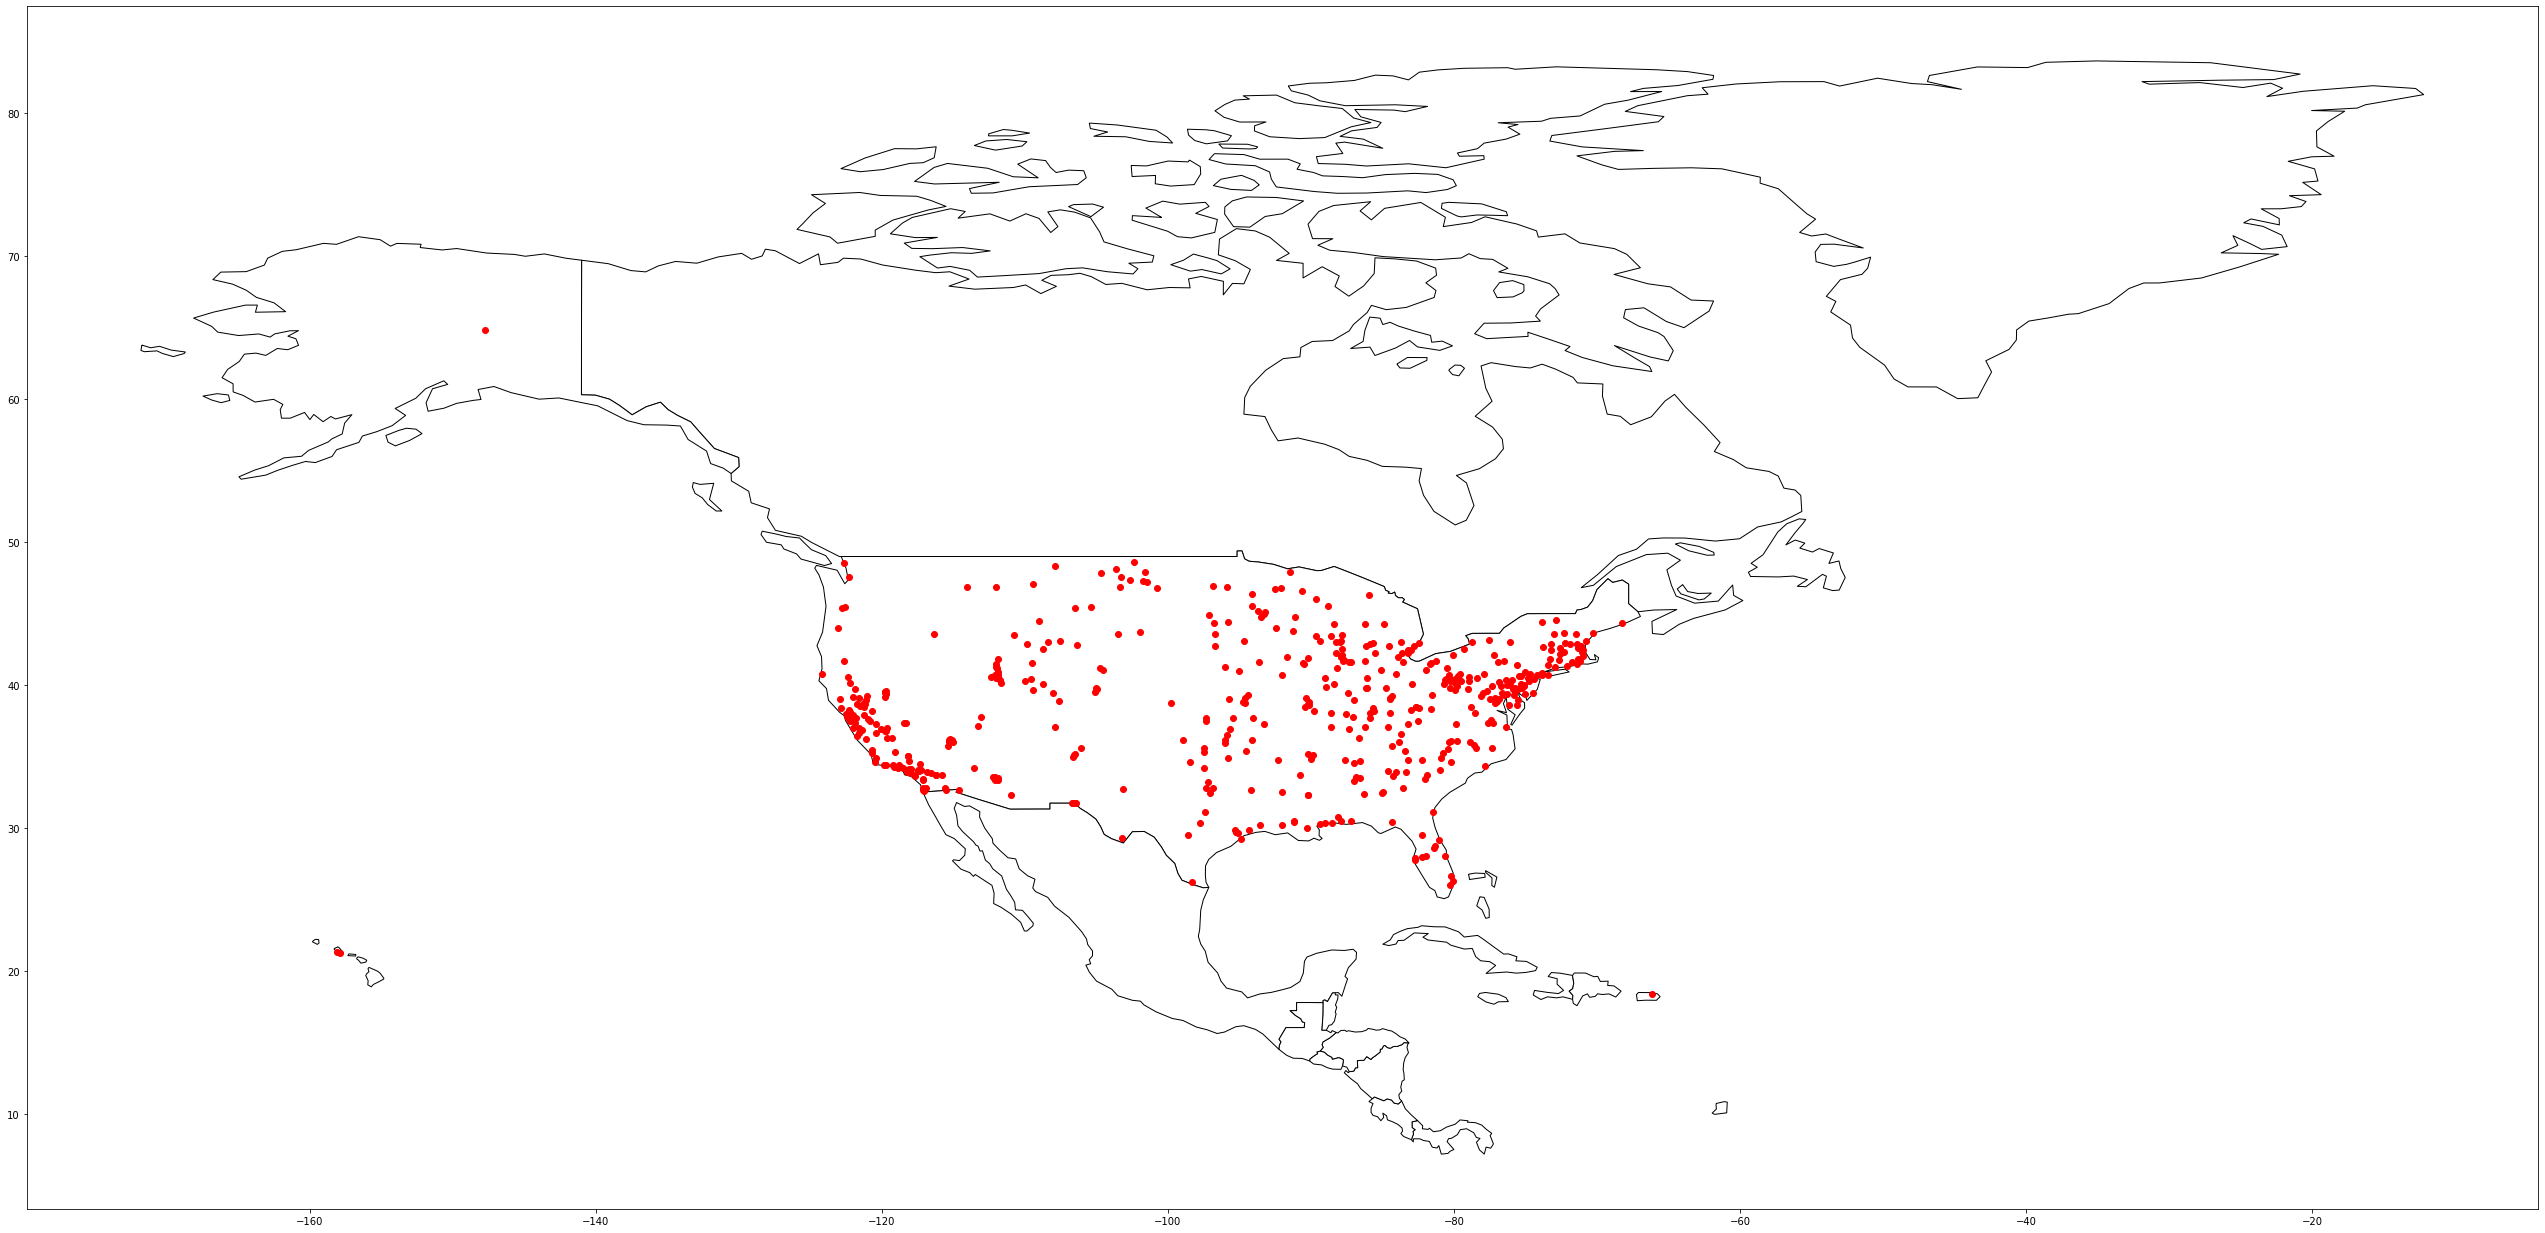

In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(45, 27))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

In [26]:
state_site_counts[state_site_counts >= 10]

STATE
Alabama           10
Arizona           11
California        90
Florida           14
Illinois          16
Indiana           11
Kentucky          16
Maryland          10
Massachusetts     10
Michigan          16
Minnesota         12
Nevada            14
New Jersey        10
New York          11
North Carolina    11
North Dakota      10
Ohio              12
Oklahoma          11
Pennsylvania      33
Texas             18
Utah              20
Virginia          11
Wisconsin         14
Wyoming           10
Name: AQS_ID, dtype: int64

In [34]:
locations_file = data_dir / 'epa_locations.csv'
locations.drop('geometry', axis=1).to_csv(locations_file, index=False)